## Graphics Showing Pollution by NUTS region and population impacted

This notebook will display graphics related to the pollution by nuts region and the number of people impacted.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

EU targets are set for pollution levels.  Targets are set for NO2, O3, PM10 an PM25.  Targets are set for different time periods: <br>
**calendar year** - Simple average of the YTD pollutant level compared to an annual average target.  Defined for NO2, PM10 and PM25. <br>
**hour** - Defined as a number of hours in a year that can exceed a defined threshold. Defined for NO2. <br>
**day** - Defined as the number of days in a year that can exceed a defined threshold. Defined for PM10. <br>
**max 8-hour mean** - Defined as a number of 8-hour periods in a year that can exceed a defined threshold. Defined for O3.<br>

All measurements are calcaulted from observation station hourly readings.



### Definition of Time Periods 
https://www.eionet.europa.eu/aqportal/doc/ETC_Aggregation_v0.8.2_final.pdf <br>
<br>
**Daily Average (24-hour Mean)** (section 4.1): <br> 
"The daily average or daily mean derived from a sample period of one day."
<br>
(http://dd.eionet.europa.eu/vocabularyconcept/aq/primaryObservation/day/view)
<br><br>
**8-hour running mean** (section 4.2): <br>
"Definition: The 8-hour running mean value for each hour is calculated as the average of the valid hourly values for that hour and the 7 previous hours (therefore cumulatively and 8-hour averaging period). Hence, the averaging period of hour1 of dayn is hour17 of dayn-1 until hour1 of dayn (inclusive). The averaging period of hour24 of dayn is hour16 of dayn until hour24 of dayn (inclusive)." <br>
<br>
**Daily Maximum 8-hour running mean** (section 4.3): <br>
Definition: The daily maximum 8-hour running mean is the maximum of the valid 8-hour running means for that day. Calculation of all the 8-hour running means (above) for a given day is a pre- requisite. A day runs from hour1 to hour24 as defined above.



In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import logging
import netCDF4
import re
import os
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import time
import string
import datetime
import pytz
import random
import math

In [10]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon, Point, MultiPolygon
import shapely.wkt

In [11]:
try:
    from django.db import models
    from airpollution.models import *
#    from airpollution.models.models_observations import *
    from airpollution.models.models_nuts import *
    from airpollution.models.models_pollutants import *
    from airpollution.views.aq_api_v1 import *
    from airpollution.views.nuts_maps_views import *

    from eugreendeal.settings import MEDIA_ROOT
except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
    
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [12]:
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, CategoricalColorMapper, LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
output_notebook()

Loading BokehJS ...

## Population Impacted
Show the map of the EU divided by NUTS regions.  Display each observation station as a point.  Color the point based on the achievement to target.  Make the size of the point as large as the most precise indication of the population in the area of the point (NUTS2 is collected in the application).

In [108]:
# df = pd.DataFrame(nuts_boundaries[nuts_level]).T.rename(columns={'geography':'geometry'})

# # convert string geometry objects to shapely objects
# def convert(s):
#     return shapely.wkt.loads(s.geometry).buffer(0)

# s_geo = df.apply(convert, axis=1)
# df['geometry'] = gpd.GeoSeries(s_geo, crs=4326)

# gdf = gpd.GeoDataFrame(df, geometry='geometry')

# minx=-24.95
# miny=30.05
# maxx=44.95
# maxy=71.95
# eu_bounds = Polygon([(minx, miny),(maxx,miny),(maxx,maxy),(minx,maxy),(minx,miny)])
# gpd.clip(gdf, eu_bounds).plot()

In [74]:
# get NUTS region per station
nuts_boundaries = get_region_boundaries_data(level=None, regions=None)
reg_df = pd.DataFrame(nuts_boundaries[0]).T.reset_index()
reg_df


,index,name,country_code,geography
0,NL,NEDERLAND,NL,MULTIPOLYGON (((7.2030000000000003 53.11299999...
1,PL,POLSKA,PL,POLYGON ((18.5420000000000016 54.5840000000000...
2,PT,PORTUGAL,PT,MULTIPOLYGON (((-8.1989999999999998 42.1540000...
3,RO,ROMÂNIA,RO,POLYGON ((27.3909999999999982 47.5889999999999...
4,MT,MALTA,MT,MULTIPOLYGON (((14.6460000000000008 35.9329999...
5,AT,ÖSTERREICH,AT,POLYGON ((16.9400000000000013 48.6169999999999...
6,BE,BELGIQUE-BELGIË,BE,POLYGON ((5.5659999999999998 51.22099999999999...
7,BG,БЪЛГАРИЯ,BG,POLYGON ((22.9660000000000011 44.0979999999999...
8,CY,ΚΥΠΡΟΣ,CY,MULTIPOLYGON (((33.6250000000000000 34.8509999...
9,CZ,ČESKÁ REPUBLIKA,CZ,POLYGON ((14.4909999999999997 51.0439999999999...


In [36]:
# get the nuts 3 region names
_n = 3
nuts_boundaries = get_region_boundaries_data(level=None, regions=None)
reg_df = pd.DataFrame(nuts_boundaries[_n]).T.reset_index().rename(columns={'name':f'nuts_{_n}_name', 'index':f'nuts_{_n}_id'})
df = df.merge(reg_df, how='inner')


NameError: name 'df' is not defined

In [163]:
df

,air_quality_station,country_code_id,air_quality_network,air_quality_station_eoicode,air_quality_station_natcode,projection,longitude,latitude,altitude,nuts_1_id,...,target_value,count_limit,measurement_id,year,achievement,radius,geometry,nuts_3_name,country_code,geography
0,STA.01.0002,AT,NET.01,AT10002,010002,EPSG:4979,16.208080,47.339410,344.0,AT1,...,40.0,NaN,calendar_year,2020,-0.678845,24,POINT (16.20808 47.33941),Südburgenland,AT,POLYGON ((16.4340000000000011 47.3530000000000...
1,STA.01.0002,AT,NET.01,AT10002,010002,EPSG:4979,16.208080,47.339410,344.0,AT1,...,40.0,NaN,calendar_year,2020,-0.491399,22,POINT (16.20808 47.33941),Südburgenland,AT,POLYGON ((16.4340000000000011 47.3530000000000...
2,STA.02.F103,AT,NET.02,AT2F103,02F103,EPSG:4979,14.266111,46.653056,455.0,AT2,...,40.0,NaN,calendar_year,2020,-0.287738,16,POINT (14.26611 46.65306),Klagenfurt-Villach,AT,POLYGON ((14.2340000000000000 46.7000000000000...
3,STA.02.M121,AT,NET.02,AT2M121,02M121,EPSG:4979,13.705000,46.558900,574.0,AT2,...,40.0,NaN,calendar_year,2020,-0.655262,6,POINT (13.70500 46.55890),Klagenfurt-Villach,AT,POLYGON ((14.2340000000000000 46.7000000000000...
4,STA.03.2302,AT,NET.03,AT32302,032302,EPSG:4979,15.620400,48.201300,271.0,AT1,...,40.0,NaN,calendar_year,2020,-0.318179,18,POINT (15.62040 48.20130),Sankt Pölten,AT,POLYGON ((15.9930000000000003 48.1460000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,STA-SK0008A,SK,NET-SK001A,SK0008A,99224,EPSG:4979,19.302525,49.079166,475.0,SK0,...,25.0,NaN,calendar_year,2020,0.067364,25,POINT (19.30252 49.07917),Žilinský kraj,SK,POLYGON ((19.8840000000000003 49.2040000000000...
375,STA-SK0214A,SK,NET-SK001A,SK0214A,99214,EPSG:4979,19.154999,48.735001,346.0,SK0,...,40.0,NaN,calendar_year,2020,-0.799950,11,POINT (19.15500 48.73500),Banskobystrický kraj,SK,POLYGON ((20.2669999999999995 48.8740000000000...
376,STA-SK0214A,SK,NET-SK001A,SK0214A,99214,EPSG:4979,19.154999,48.735001,346.0,SK0,...,25.0,NaN,calendar_year,2020,-0.793036,16,POINT (19.15500 48.73500),Banskobystrický kraj,SK,POLYGON ((20.2669999999999995 48.8740000000000...
377,STA-SK0406A,SK,NET-SK004A,SK0406A,99406,EPSG:4979,22.273610,48.935000,431.0,SK0,...,40.0,NaN,calendar_year,2020,-0.480433,7,POINT (22.27361 48.93500),Prešovský kraj,SK,POLYGON ((22.5670000000000002 49.0880000000000...


### The data method is in the API (aq_api_v1.py)

In [16]:
def get_target_bubblemap_data(start_date: str, end_date: str, pollutants: list = ('PM25', 'PM10', 'NO2')):
    # Create Data for Visualization

    # get daily average readings over date range for pollutant
    readings_df = ObservationStationReading.get_pollutant_dayavg_by_station_df(start_date, end_date, pollutants)

    # get all stations meta data
    rs_stations = ObservationStation.objects.all().values()
    stations_df = pd.DataFrame(rs_stations)

    # merge the readings with the meta data
    df = stations_df.merge(readings_df)

    def parse_nuts(s):
        return s.split('_')[-1]

    # get the nuts 2 region names
    df['nuts_1_id'] = df['nuts_1_id'].apply(parse_nuts)
    df['nuts_2_id'] = df['nuts_2_id'].apply(parse_nuts)
    df['nuts_3_id'] = df['nuts_3_id'].apply(parse_nuts)
    _n = 2
    nuts_boundaries = get_region_boundaries_data(level=None, regions=None)
    reg_df = pd.DataFrame(nuts_boundaries[_n]).T.reset_index().rename(
        columns={'name': f'nuts_{_n}_name', 'index': f'nuts_{_n}_id'})

    df = df.merge(reg_df, how='inner')

    # add targets to the measurements dataframe
    end_year = int(end_date[:4])
    t_df = Pollutant.get_targets_df(years=[end_year], pollutants=pollutants)
    t_df.rename(columns={'country': 'country_code_id', 'value': 'target_value'}, inplace=True)
    t_df = t_df[t_df['measurement_id'] == 'calendar_year']

    df = df.merge(t_df)

    # add target achievement
    df['achievement'] = (df['value__avg'] / df['target_value'])

    population = _get_nuts2_population_series()

    df = df.merge(population, left_on='nuts_2_id', right_on='nuts_2_id')

    df['radius'] = df['population'] / df['population'].max() * 50 + 10

    # create a GeoPandas Object to plot from
    rs_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    rv = {}
    for p in pollutants:
        p_gdf = rs_gdf[rs_gdf['pollutant_id'] == p]
        p_geo = GeoJSONDataSource(geojson=json.dumps(p_gdf.__geo_interface__))
        rv.update({p: p_geo})

    return rv


def _get_nuts2_population_series():
    # get nuts2 region population of most recent year
    df = pd.DataFrame(EurostatDataModel.objects.all().values('year', 'nutsRegionStr',
                                                             'population'))  # .drop(columns=['id', 'nutsRegion'])
    df = df.rename(columns={'nutsRegionStr': 'nuts_2_id'})
    df_pivot = df.pivot_table(columns=['year'], index=['nuts_2_id'])
    df_pivot.columns = df_pivot.columns.get_level_values(1)

    # get most recent year
    pop_year = df_pivot.columns[df_pivot.columns.argmax()]
    population = df_pivot[pop_year]
    population.name = 'population'

    return population

### The plot data is in the view  (nuts_maps_views.py)

In [20]:
def draw_bubble_map(request, start_date: str = None, end_date: str = None, pollutants: list = None):
    if request is not None:
        pollutants = request.GET.get('pollutants', ['PM25', 'PM10', 'NO2'])
        start_date = request.GET.get('start_date', None)
        end_date = request.GET.get('end_date', None)

        if start_date is None:
            return JsonResponse("'start_date' is a required parameter.", safe=False)

        if end_date is None:
            end_date = start_date

    bubble_data = get_target_bubblemap_data(start_date=start_date, end_date=end_date, pollutants=pollutants)

    # create bokeh elements
    _tabs = []
    for k, v in bubble_data.items():
        p = get_nuts_map(0, outline_map=True, include_tools=False)

        p.name = k
        # add annotation
        top = p.properties_with_values().get('plot_height')
        note1 = Label(x=10, y=50, x_units='screen', y_units='screen',
                      text='NOTE: bubble size denotes Nuts2 Population.', render_mode='canvas',
                      border_line_color=None, border_line_alpha=1.0, text_alpha=.5, text_font_size='12px',
                      background_fill_color=None, background_fill_alpha=0.5)
        note2 = Label(x=10, y=30, x_units='screen', y_units='screen',
                      text='NOTE: color denotes percentage of target.', render_mode='canvas',
                      border_line_color=None, border_line_alpha=1.0, text_alpha=0.5, text_font_size='12px',
                      background_fill_color=None, background_fill_alpha=0.5)
        p.add_layout(note1)
        p.add_layout(note2)
        _tabs.append(Panel(child=p, title=p.name))

    tabs = Tabs(tabs=_tabs)
    tabs.sizing_mode = 'scale_both'

    color_mapper = LinearColorMapper(palette=RdYlGn11, low=.5, low_color='green', high=1.5, high_color='red')
    tick_format = NumeralTickFormatter(format='+0%')
    color_bar = ColorBar(color_mapper=color_mapper,
                         ticker=FixedTicker(ticks=[0, .25, 0.50, .75, 1, 1.25, 1.50]),
                         formatter=tick_format,
                         label_standoff=9, border_line_color=None, location=(0, 0))

    s_zoom = WheelZoomTool()
    s_pan = PanTool()
    s_reset = ResetTool()

    # create the bubbles and hover elements
    for t in tabs.tabs:
        # add colorbar
        t.child.add_layout(color_bar, 'right')

        # add bubbles
        glyphs = t.child.scatter(x='x', y='y', size='radius', source=bubble_data.get(t.child.name),
                                 fill_alpha=0.6, fill_color={'field': 'achievement', 'transform': color_mapper},
                                 line_color=None)

        # add hover tool for stations
        hover_tool = HoverTool(renderers=[glyphs],
                               tooltips=[("air_quality_station", "@air_quality_station"),
                                         ("Country", "@country_code_id"),
                                         ("NUTS 2", "@nuts_2_name"),
                                         ("NUTS 2 Pop", "@population"),
                                         (f"{t.child.name} Target Value", "@target_value"),
                                         ("Avg Value", "@value__avg"),
                                         ("% of Target", "@achievement{:+%0.0}")])
        t.child.add_tools(hover_tool, s_zoom, s_pan, s_reset)

    # jupyter notebook
    return tabs

    # django
#     item = json_item(tabs)
    # item['metadata'] = 'somemetadata'

    return JsonResponse(item)

In [21]:

tabs = draw_bubble_map(None, start_date='2020-01-01', end_date='2020-12-31', pollutants=['PM25', 'PM10', 'NO2'])


In [22]:
show(tabs) # tabs

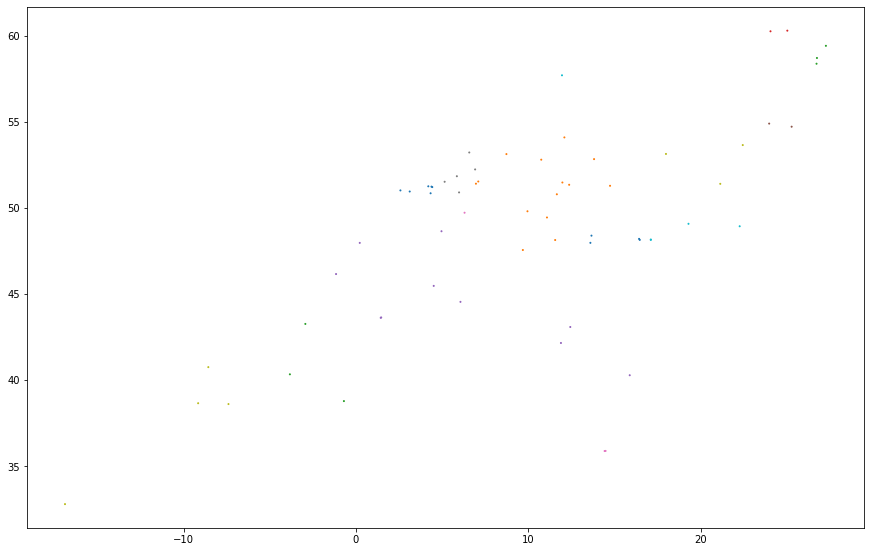

In [25]:
# all stations
rs_gdf.plot(markersize=1, figsize=(15,15), categorical = True, column='country_code_id');